In [310]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point

In [311]:
#getting the grouped nodes data

base_dir = 'D:/Desktop/MSc Thesis - Copy/'
nodes_df = pd.read_csv(os.path.join(base_dir, 'shapefiles/_network_parts_1/nodes_urban_feat.csv'), header = 0)
nodes_gdf = gpd.GeoDataFrame(nodes_df, geometry=gpd.points_from_xy(nodes_df['node_x'], nodes_df['node_y']), crs='EPSG:5174')


positions_links = pd.read_csv(os.path.join(base_dir, 'shapefiles/_network_parts_1/positions_links.csv'), header = 0)

neighborhood_extents = gpd.read_file(os.path.join(base_dir, 'shapefiles/crop/crop_neighborhood.shp'))

print(neighborhood_extents.crs) 
print(nodes_gdf.crs)

EPSG:5174
EPSG:5174


In [312]:
# remove records in nodes_gdf that have in_Seoul column as False
nodes_gdf = nodes_gdf[nodes_gdf['in_Seoul'] == True]
nodes_gdf['in_Neighborhood'] = nodes_gdf.geometry.within(neighborhood_extents.union_all())

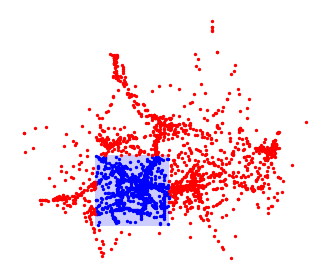

In [313]:
# plot the nodes and the neighborhood extent
fig, ax = plt.subplots(figsize=(4, 4))
neighborhood_extents.plot(ax=ax, color='blue', edgecolor=None, alpha=0.2, label='Neighborhood Extent')
nodes_gdf[nodes_gdf['in_Neighborhood']].plot(ax=ax, color='blue', markersize=2, label='Nodes in Neighborhood')
nodes_gdf[~nodes_gdf['in_Neighborhood']].plot(ax=ax, color='red', markersize=2, label='Nodes outside Neighborhood')
ax.set_axis_off()

In [314]:
# remove records outside seoul
positions_links = positions_links[~positions_links['node_id'].between(0, 8)]
positions_links = positions_links[~positions_links['prev_node_id'].between(0, 8)]

In [315]:
outer_nodes = nodes_gdf[~nodes_gdf['in_Neighborhood']]
inner_nodes = nodes_gdf[nodes_gdf['in_Neighborhood']]

In [316]:
# dividing the nodes outside Seoul into eight node IDs based on their directional quadrant:
# 1: NN, 2: NE, 3: EE, 4: SE, 5: SS, 6: SW, 7: WW, 8: NW

neighborhood_center = neighborhood_extents.union_all().centroid
center_x, center_y = neighborhood_center.x, neighborhood_center.y

def assign_cardinal_node_id(row):
    dx = row.geometry.x - center_x  # Longitude difference
    dy = row.geometry.y - center_y  # Latitude difference
    angle = np.degrees(np.arctan2(dy, dx)) # Angle in coordinates (0° = East, 90° = North)
    
    if angle < 0:
        angle += 360  # Convert angle to a 0-360° scale
    if 0 <= angle < 22.5 or angle >= 337.5:
        return 1  # EE (East)
    elif 22.5 <= angle < 67.5:
        return 2  # NE (North-East)
    elif 67.5 <= angle < 112.5:
        return 3  # NN (North)
    elif 112.5 <= angle < 157.5:
        return 4  # NW (North-West)
    elif 157.5 <= angle < 202.5:
        return 5  # WW (West)
    elif 202.5 <= angle < 247.5:
        return 6  # SW (South-West)
    elif 247.5 <= angle < 292.5:
        return 7  # SS (South)
    elif 292.5 <= angle < 337.5:
        return 8  # SE (South-East)

outer_nodes['node_id_new'] = outer_nodes.apply(assign_cardinal_node_id, axis=1)

c:\Users\Michele\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [317]:
# reassigning node ids
new_node_ids = range(9, 9 + len(inner_nodes))
inner_nodes['node_id_new'] = dict(zip(inner_nodes.index, new_node_ids)).values()

old_to_new = dict(zip(inner_nodes['node_id'], new_node_ids))
inner_nodes['new_node_id'] = inner_nodes['node_id'].map(old_to_new)

nodes_gdf.loc[outer_nodes.index, 'node_id'] = outer_nodes['node_id_new']
nodes_gdf.loc[inner_nodes.index, 'node_id'] = inner_nodes['node_id_new']

c:\Users\Michele\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\Michele\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [318]:
from matplotlib.patches import Wedge
fig, ax = plt.subplots(figsize=(4, 4))
node_colors = {
    1: "blue",      # E
    2: "green",     # NE
    3: "purple",    # N    
    4: "orange",    # NW
    5: "brown",     # W    
    6: "pink",      # SW
    7: "gray",      # S
    8: "black",     # SE
}

max_radius = max( nodes_gdf.geometry.x.max() - center_x, nodes_gdf.geometry.y.max() - center_y) * 1.2  # Scale up to ensure full coverage

for node_id, color in node_colors.items():
    start_angle = (node_id - 1) * 45 - 22.5  # Each slice is 45 degrees
    end_angle = node_id * 45 - 22.5
    wedge = Wedge((center_x, center_y), max_radius, start_angle, end_angle, color=color, alpha=0.05, label=f"Quadrant {node_id}")
    ax.add_patch(wedge)

for node_id, color in node_colors.items():
    nodes_gdf[nodes_gdf["node_id"] == node_id].plot(ax=ax, color=color, markersize=5, label=f"Node {node_id}")

neighborhood_extents.boundary.plot(ax=ax, color='red', linewidth=0.3, label="Seoul Extents")
nodes_gdf[nodes_gdf["in_Seoul"]].plot(ax=ax, color='lightgrey', markersize=1.5, label="Unknown (NaN)")

minx, miny, maxx, maxy = neighborhood_extents.total_bounds
x_margin = (maxx - minx) * 1
y_margin = (maxy - miny) * 1
ax.set_xlim(minx - x_margin, maxx + x_margin)
ax.set_ylim(miny - y_margin, maxy + y_margin)

plt.gca().set_aspect('equal')  
ax.set_axis_off()
plt.show()


In [319]:
mapping_dict = pd.concat([outer_nodes, inner_nodes]).set_index('node_id')['node_id_new'].to_dict()



all_mapped_ids = set(mapping_dict.keys())
used_ids = set(positions_links['node_id']) | set(positions_links['prev_node_id'])

missing_ids = used_ids - all_mapped_ids
print("Missing node IDs:", missing_ids)



positions_links['node_id'] = positions_links['node_id'].map(mapping_dict)
positions_links['prev_node_id'] = positions_links['prev_node_id'].map(mapping_dict)


Missing node IDs: set()


In [320]:
is_cardinal = nodes_gdf['node_id'].between(1, 8)
deduped_cardinals = nodes_gdf[is_cardinal].drop_duplicates(subset='node_id')

deduped_cardinals['in_Neighborhood'] = False
deduped_cardinals[['Indoors', 'FSI', 'GSI', 'OSR', 'ABH', 'WMHB', 'HSTD', 'GrCR', 'GD']] = np.nan
deduped_cardinals[['Indoors']] = -1
deduped_cardinals[['node_x', 'node_y']] = np.nan


non_cardinals = nodes_gdf[~is_cardinal]
nodes_gdf = pd.concat([deduped_cardinals, non_cardinals], ignore_index=True)
nodes_gdf = nodes_gdf.drop(columns=['in_Seoul'])

In [321]:
# manually setting the cardinal nodes' coordinates
max_distance = neighborhood_extents.boundary.distance(neighborhood_center).max()
print(max_distance)

offset_factor = 2
outer_radius = max_distance * offset_factor

angles = np.deg2rad([0, 45, 90, 135, 180, 225, 270, 315])  # NN, NE, EE, SE, SS, SW, WW, NW

# computing new positions for nodes 1-8
for node_id, angle in zip(range(1, 9), angles):
    x = neighborhood_center.x + outer_radius * np.cos(angle)
    y = neighborhood_center.y + outer_radius * np.sin(angle)

    nodes_gdf.loc[nodes_gdf["node_id"] == node_id, "node_x"] = x
    nodes_gdf.loc[nodes_gdf["node_id"] == node_id, "node_y"] = y
    nodes_gdf.loc[nodes_gdf["node_id"] == node_id, "geometry"] = Point(x, y)


# print the final x and y coordinates of the cardinal nodes
print("Final coordinates of cardinal nodes:")
for node_id in range(1, 9):
    coords = nodes_gdf.loc[nodes_gdf["node_id"] == node_id, ["node_x", "node_y"]].values[0]
    print(f"Node {node_id}: x = {coords[0]}, y = {coords[1]}")


4021.9658467743425
Final coordinates of cardinal nodes:
Node 1: x = 202778.51753203396, y = 444483.46754422213
Node 2: x = 200422.50448639493, y = 450171.3861921318
Node 3: x = 194734.58583848528, y = 452527.3992377708
Node 4: x = 189046.66719057562, y = 450171.3861921318
Node 5: x = 186690.6541449366, y = 444483.46754422213
Node 6: x = 189046.66719057562, y = 438795.5488963125
Node 7: x = 194734.58583848528, y = 436439.53585067345
Node 8: x = 200422.50448639493, y = 438795.5488963125


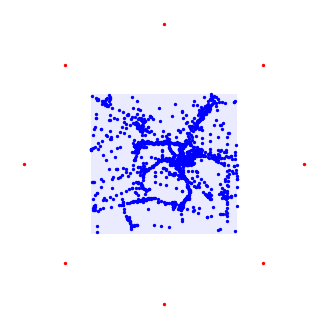

In [322]:
# plot all nodes, those ith in the neighborhood in blue, those outside in red
fig, ax = plt.subplots(figsize=(4, 4))
neighborhood_extents.plot(ax=ax, color='blue', edgecolor=None, alpha=0.08, label='Neighborhood Extent')
nodes_gdf[nodes_gdf['in_Neighborhood']].plot(ax=ax, color='blue', markersize=2, label='Nodes in Neighborhood')
nodes_gdf[~nodes_gdf['in_Neighborhood']].plot(ax=ax, color='red', markersize=2, label='Nodes outside Neighborhood')
ax.set_axis_off()
plt.show()


In [323]:
nodes_gdf.to_file(os.path.join(base_dir,"shapefiles/_network_parts_2/nodes_urban_feat.shp"))
nodes_gdf.to_csv(os.path.join(base_dir,"shapefiles/_network_parts_2/nodes_urban_feat.csv"))
positions_links.to_csv(os.path.join(base_dir,"shapefiles/_network_parts_2/positions_links.csv"))

C:\Users\Michele\AppData\Local\Temp\ipykernel_37748\1597896574.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_gdf.to_file(os.path.join(base_dir,"shapefiles/_network_parts_2/nodes_urban_feat.shp"))
c:\Users\Michele\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Unnamed: 0.1' to 'Unnamed_ 0'
  ogr_write(
c:\Users\Michele\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Unnamed: 0' to 'Unnamed__1'
  ogr_write(
c:\Users\Michele\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'in_Neighborhood' to 'in_Neighbo'
  ogr_write(
